#### Libraries

In [4]:
import numpy as np
import pandas as pd

from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Dropout, Embedding, LSTM, SpatialDropout1D
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from collections import Counter
import matplotlib.pyplot as plt

Using TensorFlow backend.


##### Getting Data

In [5]:
AllTweets_sentiments_Cleaned = pd.read_csv("AllTweets_sentiments_Cleaned.csv")
print("Positive, Negative & Neutral Tweets",AllTweets_sentiments_Cleaned.shape)

AllTweets_sentiments_Cleaned_pos = AllTweets_sentiments_Cleaned[AllTweets_sentiments_Cleaned.sentiment == 1]
print("Positive Tweets",AllTweets_sentiments_Cleaned_pos.shape)

AllTweets_sentiments_Cleaned_neg = AllTweets_sentiments_Cleaned[AllTweets_sentiments_Cleaned.sentiment == 0]
print("Negative Tweets",AllTweets_sentiments_Cleaned_neg.shape)

AllTweets_sentiments_Cleaned_pos = AllTweets_sentiments_Cleaned_pos[:3500] #taking only 3500 positive tweets

AllTweets_sentiments_Cleaned = pd.concat([AllTweets_sentiments_Cleaned_pos,AllTweets_sentiments_Cleaned_neg])
print("Positive & Negative Tweets: ", AllTweets_sentiments_Cleaned.shape) # only positve and negative tweets 

AllTweets_sentiments_Cleaned = AllTweets_sentiments_Cleaned.sample(frac=1) # Randomizing Dataframe rows

TweetsSentiments_Tweets = AllTweets_sentiments_Cleaned.Tweet  # only tweets
TweetsSentiments_sentiments = AllTweets_sentiments_Cleaned.sentiment # only sentiments

Positive, Negative & Neutral Tweets (10363, 2)
Positive Tweets (7238, 2)
Negative Tweets (3125, 2)
Positive & Negative Tweets:  (6625, 2)


### Naive Bayes Classifer

In [7]:
df = AllTweets_sentiments_Cleaned
df_pos = df.copy()[df.sentiment == 1][:3100]
df_neg = df.copy()[df.sentiment == 0][:3100]
df_neu = pd.DataFrame()
df = pd.concat([df_pos, df_neg], ignore_index=True).reset_index(drop=True)
df.shape

(6200, 2)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df['Tweet'], df['sentiment'], test_size=0.25, random_state=0)

df_train = pd.DataFrame()
df_test = pd.DataFrame()

df_train['Tweet'] = X_train
df_train['sentiment'] = y_train
df_train = df_train.reset_index(drop=True)

df_test['Tweet'] = X_test
df_test['sentiment'] = y_test
df_test = df_test.reset_index(drop=True)

print("Train data",df_train.shape)
print("Test data",df_test.shape)

Train data (4650, 2)
Test data (1550, 2)


In [9]:
class Naive_Classifier(object): 
    def __init__(self, df_train):
        self.df_train = df_train
        self.df_pos = df_train.copy()[df_train.sentiment == 1]
        self.df_neg = df_train.copy()[df_train.sentiment == 0]

    def fit(self):
        Pr_pos = df_pos.shape[0]/self.df_train.shape[0]
        Pr_neg = df_neg.shape[0]/self.df_train.shape[0]
        self.Prior  = (Pr_pos, Pr_neg)

        self.pos_words = ' '.join(self.df_pos['Tweet'].tolist()).split()
        self.neg_words = ' '.join(self.df_neg['Tweet'].tolist()).split()        

        all_words = ' '.join(self.df_train['Tweet'].tolist()).split()

        self.vocab = len(Counter(all_words))

        wc_pos = len(' '.join(self.df_pos['Tweet'].tolist()).split())
        wc_neg = len(' '.join(self.df_neg['Tweet'].tolist()).split())
        self.word_count = (wc_pos, wc_neg)
        return self

    def predict(self, df_test):
        class_choice = [1,0]

        classification = []
        for tweet in df_test['Tweet']:
            text = tweet.split()

            val_pos = np.array([])
            val_neg = np.array([])
            val_neu = np.array([])
            for word in text:
                tmp_pos = np.log((self.pos_words.count(word)+1)/(self.word_count[0]+self.vocab))
                tmp_neg = np.log((self.neg_words.count(word)+1)/(self.word_count[1]+self.vocab))                
                val_pos = np.append(val_pos, tmp_pos)
                val_neg = np.append(val_neg, tmp_neg)

            val_pos = np.log(self.Prior[0]) + np.sum(val_pos)
            val_neg = np.log(self.Prior[1]) + np.sum(val_neg)

            probability = (val_pos, val_neg)
            classification.append(class_choice[np.argmax(probability)])
        return classification

    def score(self, feature, target):
        compare = []
        for i in range(0,len(feature)):
            if feature[i] == target[i]:
                tmp ='correct'
                compare.append(tmp)
            else:
                tmp ='incorrect'
                compare.append(tmp)
        r = Counter(compare)
        accuracy = r['correct']/(r['correct']+r['incorrect'])
        return accuracy

In [10]:
tnb = Naive_Classifier(df_train)
tnb = tnb.fit()
predict = tnb.predict(df_test)
score = tnb.score(predict,df_test.sentiment.tolist())
score = score * 100
print(score)

91.09677419354838


### Deep Neural Network

In [48]:
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures)
tokenizer.fit_on_texts(TweetsSentiments_Tweets)
word_index = tokenizer.word_index

X = tokenizer.texts_to_sequences(TweetsSentiments_Tweets)
X = pad_sequences(X)

In [49]:
GLOVE_DIM = 100
glove_file = 'glove.twitter.27B.' + str(GLOVE_DIM) + 'd.txt'
emb_dict = {}
glove = open(glove_file, encoding="utf8")
for line in glove:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], dtype='float32')
    emb_dict[word] = vector
glove.close()

In [51]:
NB_WORDS = 10000
emb_matrix = np.zeros((NB_WORDS, GLOVE_DIM))

for w, i in tokenizer.word_index.items():
    if i < NB_WORDS:
        vect = emb_dict.get(w)        
        if vect is not None:
            emb_matrix[i] = vect
    else:
        break

In [52]:
embed_dim = 100
lstm_out = 196
model = Sequential()
model.add(Embedding(10000, embed_dim))
model.add(Dropout(0.5))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
model.layers[0].set_weights([emb_matrix])
model.layers[0].trainable = False
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
dropout_7 (Dropout)          (None, None, 100)         0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 196)               232848    
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 394       
Total params: 2,233,242
Trainable params: 1,233,242
Non-trainable params: 1,000,000
_________________________________________________________________
None


In [74]:
Y = pd.get_dummies(TweetsSentiments_sentiments).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.25, random_state = 42)

print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(4968, 59) (4968, 2)
(1657, 59) (1657, 2)


In [75]:
X_val = X_train[:1000] # taking 1000 samples for validation and rest for training
Y_val = Y_train[:1000]

In [76]:
partial_X_train = X_train[1000:]
partial_Y_train = Y_train[1000:]

In [77]:
batch_size = 100
history = model.fit(partial_X_train, 
                    partial_Y_train, 
                    epochs = 9, 
                    batch_size=batch_size, 
                    validation_data=(X_val, Y_val))

Train on 3968 samples, validate on 1000 samples
Epoch 1/9
3968/3968 [==============================] - 27s 7ms/step - loss: 0.0725 - acc: 0.9756 - val_loss: 0.2469 - val_acc: 0.9230
Epoch 2/9
3968/3968 [==============================] - 27s 7ms/step - loss: 0.0604 - acc: 0.9793 - val_loss: 0.2188 - val_acc: 0.9320
Epoch 3/9
3968/3968 [==============================] - 27s 7ms/step - loss: 0.0548 - acc: 0.9808 - val_loss: 0.2228 - val_acc: 0.9310
Epoch 4/9
3968/3968 [==============================] - 27s 7ms/step - loss: 0.0563 - acc: 0.9791 - val_loss: 0.2156 - val_acc: 0.9240
Epoch 5/9
3968/3968 [==============================] - 29s 7ms/step - loss: 0.0499 - acc: 0.9803 - val_loss: 0.2378 - val_acc: 0.9320
Epoch 6/9
3968/3968 [==============================] - 30s 8ms/step - loss: 0.0467 - acc: 0.9834 - val_loss: 0.2300 - val_acc: 0.9310
Epoch 7/9
3968/3968 [==============================] - 29s 7ms/step - loss: 0.0379 - acc: 0.9859 - val_loss: 0.2810 - val_acc: 0.9300
Epoch 8/9
3968

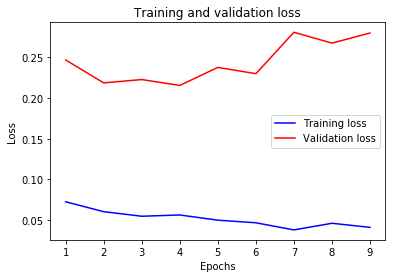

In [78]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

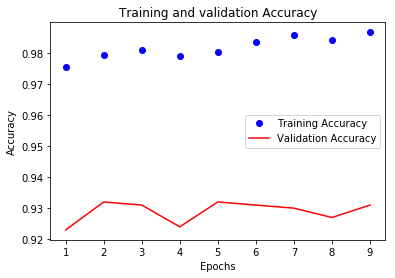

In [79]:
plt.clf()
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [80]:
pos_cnt, neg_cnt, pos_correct, neg_correct = 0, 0, 0, 0
for x in range(len(X_val)):
    
    result = model.predict(X_val[x].reshape(1,X_test.shape[1]),batch_size=1,verbose = 2)[0]
   
    if np.argmax(result) == np.argmax(Y_val[x]):
        if np.argmax(Y_val[x]) == 0:
            neg_correct += 1
        else:
            pos_correct += 1
       
    if np.argmax(Y_val[x]) == 0:
        neg_cnt += 1
    else:
        pos_cnt += 1

print("Positive Accuracy: ", pos_correct/pos_cnt*100, "%")
print("Negative Accuracy: ", neg_correct/neg_cnt*100, "%")

Positive Accuracy:  94.13919413919413 %
Negative Accuracy:  91.85022026431719 %


In [73]:
results = model.evaluate(X_test, Y_test)
print(results)

1988/1988 [==============================] - 4s 2ms/step
[0.22266363868231265, 0.9295774647887324]
